Testing the programwith the M8190A AWG


Here we import the sweeping functions from the Sweeping Module

In [70]:
%matplotlib inline 

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.animation import FuncAnimation
#Importing the functions from the module
from Sweeping import sweep0, Sweep

In [2]:
import pyvisa as visa
rm = visa.ResourceManager()
print(rm.list_resources())

('TCPIP0::ibn3-036.ibn-net.kfa-juelich.de::hislip0::INSTR',)


In [3]:
M8190A = rm.open_resource('TCPIP0::ibn3-036.ibn-net.kfa-juelich.de::hislip0::INSTR')

In [4]:
print(M8190A)

TCPIPInstrument at TCPIP0::ibn3-036.ibn-net.kfa-juelich.de::hislip0::INSTR


In [5]:
M8190A.query("*IDN?")

'Agilent Technologies,M8190A,MY57701776,5.6.0.0-2\n'

In [5]:
M8190A.read_termination = '\n'
M8190A.write_termination = '\n'
M8190A.query('*IDN?')

'Agilent Technologies,M8190A,MY57701776,5.6.0.0-2'

Important things to note:

RELATION BETWEEN SAMPLE RATE AND FRECUENCY.

AC NOT "WORKING" ANYMORE.

SOFTWARE CREATES TEMPORARYFILES WITH THE CORRESPONDING SPECIFICATIONS AND THEN IMPORTS THEM

## Instrument Initialitaion

In [14]:
M8190A.write('*CLS')

5

In [278]:
M8190A.write('*RST') #Reseting the instrument to factory settings

5

In [240]:
M8190A.write('INST:COUP:STAT 0') #Decoupling the channels

17

In [241]:
M8190A.write('OUTP1:ROUT DC') #setting the output to DC 

14

In [242]:
M8190A.write('OUTP1 ON') #activating the output "Amp Out"

9

# Amplitude

In [177]:
M8190A.write('DC1:VOLT:AMPL 0.3') #Setting voltage amplitude to 300mlv

18

I have to read more about the relation between the sample rate and the frecuency. When importing the previous data for the sine wave and running the instrumment without defyning the proper sample rate, the resulting wave will not have the corresponding frecuency as measured by the oscilloscope.

In [149]:
M8190A.write('TRAC1:SEL 2') #Selecting the sequence ID to run

12

In [213]:
M8190A.write('INIT:IMM')#Running the waveform

9

...

In [212]:
M8190A.write('ABOR') #self explanatory

5

Misc.

In [87]:
M8190A.query('*OPC?') #this is for checking that the previous commands were completed

'1'

In [272]:
M8190A.write('TRAC1:DEL:ALL')

14

# Pulses

Time is given in seconds, Amplitude is Voltage in milivolts.

In [26]:
Rabi={
    'Amplitude':10,
    'Start time':1e-10,
    'End time':2e-10,
    'Start Duration':5,
    'End Duration':6,
    'Sweep time':0,
    'Sweep Duration':0
}

In [27]:
Probe0={
    'Amplitude':2 ,
    'Start time':5,
    'End time':35,
    'Start Duration':3,
    'End Duration':8,
    'Sweep time':0,
    'Sweep Duration':1
}

In [193]:
Probe1={
    'Amplitude':2,
    'Start time':5,
    'End time':20,
    'Start Duration':7,
    'End Duration':9 ,
    'Sweep time':1,
    'Sweep Duration':0
}

In [194]:
Probe2={
    'Amplitude':6,
    'Start time':16,
    'End time':21,
    'Start Duration':4,
    'End Duration':9,
    'Sweep time':1,
    'Sweep Duration':1
}

In [30]:
Probe3={
    'Amplitude':5,
    'Start time':5,
    'End time':10,
    'Start Duration':1,
    'End Duration':5,
    'Sweep time':1,
    'Sweep Duration':0
}

In [31]:
PulsoG={
    'Amplitude':6,
    'Start time':0,
    'End time':9,
    'Start Duration':2,
    'End Duration':6 ,
    'Sweep time':1,
    'Sweep Duration':1
}

In [32]:
PulsoH={
    'Amplitude':6,
    'Start time':4,
    'End time':9,
    'Start Duration':3,
    'End Duration':5,
    'Sweep time':1,
    'Sweep Duration':1
}

## Pulse schemes = Lists of the dictionaries

In [195]:
Pulses_List3 = [
    Rabi, Probe1, Probe2
    ];


Pulses_List = [
    Rabi,Probe1
    ]  ;



Pulses_List2 = [
    Rabi,Probe2
    ];

PScheme=[
    Rabi,Probe0
    ]

## Testing

In [267]:
#Pulse List_2
pul3,timm = Sweep(Pulses_List3,100,0,31,7000) #pulse list 3
pobos0,trog1 = Sweep(Pulses_List2,100,0,31,1000); #Starting point
pobos50, trog1 = Sweep(Pulses_List2,100,50,31,1000); #Midle Point
pobos100, trog1 = Sweep(Pulses_List2,100,100,31,1000); #End Point

In [268]:
pul3n=np.array([i/np.amax(pul3) for i in pul3])

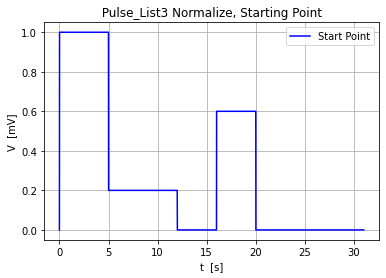

In [269]:
fig,ax= plt.subplots()



ax.grid(True)
plt.plot(timm,pul3n,'-b',label='Start Point')
ax.set_ylabel('V  [mV]')
ax.set_xlabel('t  [s]')
ax.set_title(' Pulse_List3 Normalize, Starting Point ')
ax.legend(loc=0)
plt.show()
#fig.savefig('Pulse_sweep_t=20',optimize=True,bbox_inches='tight')

In [206]:
Pulses_List3

[{'Amplitude': 10,
  'Start time': 1e-10,
  'End time': 2e-10,
  'Start Duration': 5,
  'End Duration': 6,
  'Sweep time': 0,
  'Sweep Duration': 0},
 {'Amplitude': 2,
  'Start time': 5,
  'End time': 20,
  'Start Duration': 7,
  'End Duration': 9,
  'Sweep time': 1,
  'Sweep Duration': 0},
 {'Amplitude': 6,
  'Start time': 16,
  'End time': 21,
  'Start Duration': 4,
  'End Duration': 9,
  'Sweep time': 1,
  'Sweep Duration': 1}]

time interval: 31s\\

number of points: 6000 \\

time resolution: $\frac{31}{6000} =  0.00516$ \\

sampling rate: $\frac{6000}{0.00516} = 1162790.7$

In [275]:
len(pul3n)

7000

In [270]:
np.savetxt("Pul3n.csv", pul3n, delimiter=",")

In [273]:
M8190A.write('TRAC1:IQIM 2, "C:\\Users\\a.hernandez.de.la.ve\\Documents\\GitHub\\STM\\M8190\\Pul3n.csv", CSV, BOTH, ON, ALEN')

104

In [276]:
M8190A.query(':TRAC1:CAT?') #catalogue of the corresponding traces stored in memory

'2,42000'

In [265]:
M8190A.write('FREQ:RAST ')

14

In [266]:
M8190A.query('FREQ:RAST?')

'1.25000000000000E+08'

In [252]:
M8190A.write('TRAC1:SEL 2')

12

In [251]:
M8190A.write('DC1:VOLT:AMPL 0.2')

18

In [253]:
M8190A.write('INIT:IMM')

9

In [277]:
M8190A.write('ABOR')

5

# For pulse List 2

In [36]:
pobos0n=np.array([i/np.amax(pobos0) for i in pobos0])

In [37]:
np.savetxt("pobos0n.csv", pobos0n, delimiter=",")

In [178]:
M8190A.write('TRAC1:IQIM 1, "C:\\Users\\a.hernandez.de.la.ve\\Documents\\GitHub\\STM\\M8190\\pobos0n.csv", CSV, BOTH, ON, ALEN')

106

In [274]:
M8190A.query(':TRAC1:CAT?') #catalogue of the corresponding traces stored in memory

'2,42000'

Should sample rate match in a way the number of samples? in which way_

In [179]:
M8190A.write('FREQ:RAST 768000000') #still not sure which value of sampling rate should I put here...

20

In [202]:
M8190A.query('FREQ:RAST?')

'7.68000000000000E+08'

In [183]:
M8190A.write('TRAC1:SEL 1')

12

In [184]:
M8190A.write('INIT:IMM')

9

In [215]:
M8190A.write('ABOR')

5

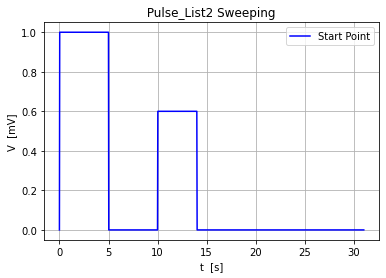

In [71]:
fig,ax= plt.subplots()



ax.grid(True)
plt.plot(trog1,pobos0n,'-b',label='Start Point')#blue  = start
#plt.plot(trog1,pobos50,'-g',label='Midle Point') #green = mittel
#plt.plot(trog1,pobos100,'-r',label='End Point') #red = end
ax.set_ylabel('V  [mV]')
ax.set_xlabel('t  [s]')
ax.set_title(' Pulse_List2 Sweeping ')
ax.legend(loc=0)
plt.show()
#fig.savefig('Pulse_sweep_t=20',optimize=True,bbox_inches='tight')

In [13]:
Pulses_List2

[{'Amplitude': 10,
  'Start time': 1e-10,
  'End time': 2e-10,
  'Start Duration': 5,
  'End Duration': 6,
  'Sweep time': 0,
  'Sweep Duration': 0},
 {'Amplitude': 6,
  'Start time': 10,
  'End time': 21,
  'Start Duration': 4,
  'End Duration': 9,
  'Sweep time': 1,
  'Sweep Duration': 1}]

### Animation

In [22]:
%matplotlib notebook
plt.style.use('seaborn-pastel')
fig = plt.figure()
ax = plt.axes(xlim=(-1, 32), ylim=(0, 11))
ax.grid(True)
ax.set_ylabel('V  [mV]')
ax.set_xlabel('t  [s]')
line, = ax.plot([], [], color='black')

# initialization function: plot the background of each frame
def init():
    line.set_data([], [])
    return line,

# animation function.  Whe iterate over n and define the stopping point by the end value of frames in the anim function
def animate(i):
    y, time = Sweep(Pulses_List,100,i,32,1000)
    line.set_data(time, y)
    return line,

# call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,frames=np.linspace(0,100), interval=400, blit=True)
plt.show()

#in our case, frames should match to the total number of time steps N

<IPython.core.display.Javascript object>

## To Do:
1. Code a "Rescale voltage program" to the obtain the dserided pulse amplitude by the given voltage output of the instrument.
2. Calculate the  $\Delta \tau$ and study it's relation with the sample size and sampling rate, code this relation so we can get this parameters by any given  $\Delta \tau$.
3. Investigate the minimum number of samples allowed by the instrument.